In [16]:
# connect to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
!unzip -uq /content/drive/MyDrive/AdvancedDeepLearning/Project/val.zip -d data
!unzip -uq /content/drive/MyDrive/AdvancedDeepLearning/Project/train.zip -d data
!unzip -uq /content/drive/MyDrive/AdvancedDeepLearning/Project/test.zip -d data

In [1]:
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]
size = 256

train_transform = T.Compose([
  T.Resize([256, 256]),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
])

test_transform = T.Compose([
  T.Resize([size, size]),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
])

val_transform = T.Compose([
  T.Resize([size, size]),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
])


train_dataset = ImageFolder('data/train', train_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = ImageFolder('data/test', test_transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

val_dataset = ImageFolder('data/val', val_transform)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

In [2]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([32, 3, 256, 256])
Labels batch shape: torch.Size([32])


In [4]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [9]:
from torchvision import models
from torch import nn
def create_model(n_classes, pt=True):
  model = models.resnet18(pretrained=pt)

  n_features = model.fc.in_features
  model.fc = nn.Linear(n_features, n_classes)

  return model.to(device)

In [10]:
model = create_model(1)

In [11]:
# If we want to freeze some of the first layers
freeze = 0
child = 0
for name, module in model.named_children():
  print(name)
  child += 1
  if (module):
    for name, param in module.named_parameters():
      if child < freeze:
        param.requires_grad = False
      print('\t',name, '\trequires grad:', param.requires_grad)

conv1
	 weight 	requires grad: True
bn1
	 weight 	requires grad: True
	 bias 	requires grad: True
relu
maxpool
layer1
	 0.conv1.weight 	requires grad: True
	 0.bn1.weight 	requires grad: True
	 0.bn1.bias 	requires grad: True
	 0.conv2.weight 	requires grad: True
	 0.bn2.weight 	requires grad: True
	 0.bn2.bias 	requires grad: True
	 1.conv1.weight 	requires grad: True
	 1.bn1.weight 	requires grad: True
	 1.bn1.bias 	requires grad: True
	 1.conv2.weight 	requires grad: True
	 1.bn2.weight 	requires grad: True
	 1.bn2.bias 	requires grad: True
layer2
	 0.conv1.weight 	requires grad: True
	 0.bn1.weight 	requires grad: True
	 0.bn1.bias 	requires grad: True
	 0.conv2.weight 	requires grad: True
	 0.bn2.weight 	requires grad: True
	 0.bn2.bias 	requires grad: True
	 0.downsample.0.weight 	requires grad: True
	 0.downsample.1.weight 	requires grad: True
	 0.downsample.1.bias 	requires grad: True
	 1.conv1.weight 	requires grad: True
	 1.bn1.weight 	requires grad: True
	 1.bn1.bias 	requir

In [12]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for inputs, labels in tqdm(data_loader):
    inputs = inputs.to(device)
    labels = labels.unsqueeze(1).to(device).float()

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = loss_fn(outputs, labels)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()

    y_pred = torch.round(torch.sigmoid(outputs))
    correct_predictions += torch.sum(y_pred == labels)


  return correct_predictions.double() / n_examples, np.mean(losses)

In [14]:
from torch import optim
from torch.utils.tensorboard import SummaryWriter

training = False
if training: 

  #optimizer = optim.Adam(model.parameters(), lr=0.0001)
  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
  loss_fn = nn.BCEWithLogitsLoss()

  n_epochs = 10
  writer = SummaryWriter()

  for epoch in range(n_epochs):
    print(f'\n[Epoch {epoch + 1}/{n_epochs}]\n')

    train_acc, train_loss = train_epoch(model, train_loader, loss_fn, optimizer, device, len(train_dataset))
    writer.add_scalar('training loss', train_loss, epoch) 
    writer.add_scalar('training acc', train_acc, epoch) 
    print(f'\nTrain loss {train_loss} accuracy {train_acc}',end='\n')
  torch.save(model.state_dict(), 'resnet18_256_sgd.pth')

else:
  model = create_model(1)
  model.load_state_dict(torch.load('resnet18_256_sgd.pth') )
  model.eval()


In [15]:
def validate(net, loader, print_flag = False):
  print("\nTesting network:")
  correct = 0
  total = 0
  
  with torch.no_grad():
    for inputs, labels in tqdm(loader):
      inputs = inputs.to(device)
      labels = labels.unsqueeze(1).to(device)
      
      outputs = net(inputs)
      y_pred = torch.round(torch.sigmoid(outputs))
      #correct += torch.sum(y_pred == labels)
      correct += (y_pred == labels).sum().float()
      total += labels.size(0)
    if print_flag:
      print("\nTotal accuracy of net: %.3f%%" % (correct/total*100))
    return correct/total

In [18]:
from tqdm import tqdm
model = model.eval()
test_accuracy = validate(model, test_loader)
val_accuracy = validate(model, val_loader)

  1%|▏         | 1/78 [00:00<00:12,  6.40it/s]


Testing network:


 50%|█████     | 1/2 [00:00<00:00,  7.42it/s]


Total accuracy of net: 95.994%

Testing network:


100%|██████████| 2/2 [00:00<00:00,  6.71it/s]


Total accuracy of net: 93.750%


In [21]:
print('Accuracy of test set: %.3f%%' % (test_accuracy*100))
print('Accuracy of val set: %.3f%%' % (val_accuracy*100))

Accuracy of test set: 95.994%
Accuracy of val set: 93.750%


In [22]:
def validate_confusion(net, loader):
    correct = 0
    total = 0
    cmatrix = torch.zeros(2,2, dtype=torch.int)
    with torch.no_grad():
        for inputs, labels in tqdm(loader):
            inputs = inputs.to(device)
            labels = labels.unsqueeze(-1).to(device)

            outputs = net(inputs)
            y_pred = torch.round(torch.sigmoid(outputs))
            stacked = torch.stack((labels, y_pred),dim=1)
            for i in stacked:
                act, pre = i.tolist()
                cmatrix[act,pre] = cmatrix[act, pre] + 1
        return cmatrix
    

In [23]:
val_cmt = validate_confusion(model, val_loader)
test_cmt = validate_confusion(model, test_loader)

100%|██████████| 78/78 [00:11<00:00,  6.57it/s]


In [24]:
print('Confusion matrix, test set: \n', test_cmt.numpy())
print('\nConfusion matrix, validation set: \n', val_cmt.numpy())

Confusion matrix, test set: 
 [[214  20]
 [  5 385]]

Confusion matrix, validation set: 
 [[7 1]
 [0 8]]


In [28]:
# F-score
from sklearn.metrics import f1_score

def get_f_score(model, loader):
  y_true  = []
  y_pred = []
  
  with torch.no_grad():
    for inputs, labels in tqdm(loader):
      inputs = inputs.to(device)
      labels = labels.unsqueeze(-1).to(device)
      outputs = model(inputs)
      pred = torch.round(torch.sigmoid(outputs))
      
      y_true += labels.squeeze(-1).cpu().tolist()
      y_pred += pred.squeeze(-1).cpu().tolist()
  
  return f1_score(y_true, y_pred)

f_score_test = get_f_score(model, test_loader)
f_score_val = get_f_score(model, val_loader)
#print('F-score on test set:', round(get_f_score(model, test_loader), 4))
#print('F-score on validation set:', round(get_f_score(model, val_loader), 4))

100%|██████████| 2/2 [00:00<00:00,  6.56it/s]


In [35]:
print('F-score on test set:', round(f_score_test, 4))
print('F-score on val set:', round(f_score_val, 4))

F-score on test set: 0.9686
F-score on val set: 0.9412


In [41]:
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, cmap=plt.cm.Blues, name=''):

    plt.figure(figsize=(4, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes, rotation=90)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), 
                 horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix_'+name+'.png', dpi = 600)


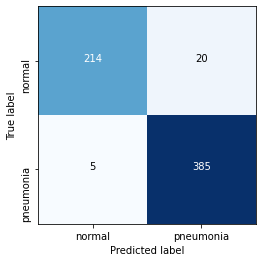

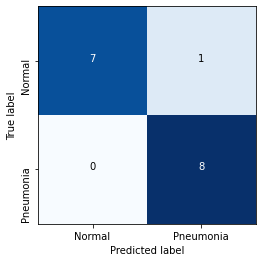

In [42]:
plot_confusion_matrix(test_cmt, ['normal','pneumonia'], name = 'test')
plot_confusion_matrix(val_cmt, ['Normal','Pneumonia'], name = 'val')

## GRAD-Cam:
For more general information [Grad-cam](http://gradcam.cloudcv.org/).
The Goal is to visualize the gradiant classification on the final Relu layer. The hope is trasform this gradiant into a heat map to in more detail see what it missclassify. In Medical field this could be very usefull. 

Similar work : [Lightweight_Deep_Learning_Models_for_Detecting_COVID-19_from_Chest_X-ray](https://www.researchgate.net/publication/347489450_Lightweight_Deep_Learning_Models_for_Detecting_COVID-19_from_Chest_X-ray_Images#pf11)

### Implementation
For implementing grad-cam we hooked the final layer of the resnet18 to a pytorch hook, and registerd the gradiants. Then with OpenCV2 constructed an heatmap and superimposed it to the input image.



In [43]:
# upload grad_cam.py
from google.colab import files
uploaded = files.upload()

Saving grad_cam.py to grad_cam.py


In [57]:
# original Github https://github.com/kazuto1011/grad-cam-pytorch/blob/master/main.py

from grad_cam import (
    BackPropagation,
    Deconvnet,
    GradCAM,
    GuidedBackPropagation,
    occlusion_sensitivity,
)


def get_heatmap(images, target_class=1,target_layers = ["layer1", "layer2", "layer3", "layer4"]):

    gcam = GradCAM(model=model)
    pred, _id = gcam.forward(images)
    gcam.backward(ids=_id)

    for i,target_layer in enumerate(target_layers):
        if i == 0:
            regions= gcam.generate(target_layer=target_layer)
        region = (gcam.generate(target_layer=target_layer))
        regions = torch.cat((region, regions), dim=1)
        # print(target_layer, region.size())


    return torch.mean(regions, dim=1).squeeze()

In [58]:
import cv2
import numpy as np


def grad_cam(img, heatmap, txt):
    # heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    img = cv2.rotate(img, cv2.cv2.ROTATE_90_CLOCKWISE)
    # img = rgb_to_brgb(img , const_alpha)

    img = heatmap * 0.4 + img

    img = cv2.rectangle(img, (5,220), (200, 250), (0,0,0), -1)
    img = cv2.resize(img, (640,480))
    cv2.putText(img, txt,(150,430), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.4, (0,150,100), 1)

    cv2.imshow('image', img)
    
def rgb_to_brgb(img, alpha):
    b_channel, g_channel, r_channel = cv2.split(img)
    alpha_channel = np.ones(b_channel.shape, dtype=b_channel.dtype) * alpha(img)
    img_BGRA = cv2.merge((b_channel, g_channel, r_channel, alpha_channel))
    return img_BGRA

In [60]:
images, id_ = next(iter(test_loader))

test = model(images.to(device))
test = torch.round(torch.sigmoid(test))
c = {0: "Normal", 1: "Pnemonia"}

images = images.to(device)
heatmap = get_heatmap(images, target_layers=["layer4"])
#heatmap = get_heatmap(images)
images =  images.permute(0,2,3,1)
images = images.cpu().numpy() 
heatmap = heatmap.cpu().numpy()
heatmap = np.vstack([heatmap])



/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


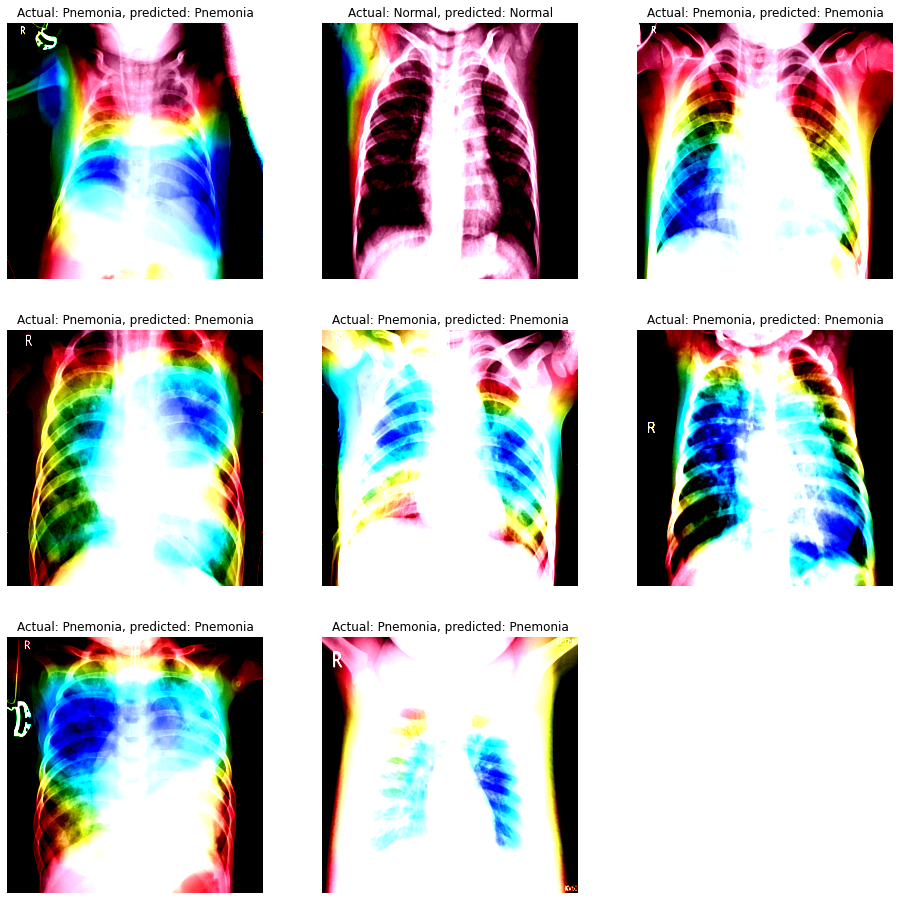

In [61]:
plt.figure(figsize=(16, 16))
for i in range(8):
    ax = plt.subplot(3, 3, i + 1)
    img = images[i]
    hm = heatmap[i]

    hm = np.uint8(255 * hm)
    hm = cv2.applyColorMap(hm, cv2.COLORMAP_JET)

    img = hm * 0.0045 + img
    plt.imshow(img)
    plt.title(f"Actual: {c[id_[i].item()]}, predicted: {c[test[i].item()]}")
    plt.axis("off")

## Datainbalance
This dataset, has lage imbalance where there is 3x as many positive cases as normal. This could be preferable as there would be better to classify a normal as sick then to missclassify someone sick as normal. However if the network is just registering people as sick then we have a problem. Altho the Grad-Cam can visualize what it missclassify. There is a need while to address the data imbalance to futher improve networks accuracy. I propose an Randomized sub-sampeling algorithm that selects from the .

### Algorithm
First assign a uniform random value to each label in the dataset. Then 
load the dataset in chunks of arbitrary size. The chunk loads a subsample of each label, the size of each labels subsamble is determined by the assosiated random value of the label assinged previously.
Finally populate the resulting batch with item from the generated subsamples.
